In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append("C:/Users/w510663/Desktop/Pyri/connections/")
from conn import snowflake_conn

conn = snowflake_conn()
cur = conn.cursor()

cur.execute('''
    SELECT DISTINCT FE.CUST_ID, FE.SETID, FE.REF_DATE, FE.A_NAICS_2_DIGIT_C, FE.A_TENURE_MONTHS_N, FE.A_FLAG_REVOLVER_B, FE.A_YEARS_IN_BUSINESS_APP_N, FE.A_FLEET_SIZE_APP_N,
        FE.D_SPREAD_EXPOSURE_6M_N, FE.D_MAX_DAYS_PAST_DUE_6M_N, FE.D_MAX_EXPOSURE_1M_N, FE.D_DAYS_SINCE_LAST_SUSPENSION_CURRENT_N, FE.D_DAYS_SINCE_LAST_30DPD_CURRENT_N, 
        FE.D_DAYS_PAST_DUE_CURRENT_N, FE.D_SPREAD_FRAC_UNBILLED_6M_N, FE.D_MAX_FRAC_UNBILLED_1M_N, FE.D_MAX_DAYS_PAST_DUE_1M_N,
        FE.DNB_COMMERCIAL_CREDIT_SCORE_CURRENT_N, FE.DNB_FINANCIAL_STRESS_SCORE_CURRENT_N,
        FE.LN_LEXISNEXIS_SCORE_CURRENT_N, FE.LN_LEXISNEXIS_SBFE_SCORE_CURRENT_N,
        FE.T_TOTAL_TRX_NON_FUEL_PROPORTION_1M_N, FE.T_SPREAD_GROSS_SPEND_6M_N, FE.T_SPREAD_TOTAL_TRX_6M_N, FE.T_SUM_GALLONS_1M_N, FE.T_SPREAD_SUM_GALLONS_6M_N,
        FE.FLAG_60_DPD_366_DAYS,
        FE.FLAG_90_DPD_366_DAYS, FE.A_BUSINESS_PROGRAM_C, FE.A_MARKETING_CHANNEL_C, FE.FLAG_CHARGEOFF_366_DAYS, FE.A_PORTFOLIO_C,
        FL.EXCL_PORTFOLIO_FLAG, FL.EXCL_CUST_STATUS_FLAG, FL.EXCL_CUST_TENURE_FLAG, FL.EXCL_GOV_VIP_FLAG, FL.EXCL_DUMMY_CREDIT_LIMIT_FLAG, FL.EXCL_LARGE_CREDIT_LIMIT_FLAG,
        FL.EXCL_MATERIAL_DELINQUENCY_FLAG, FL.EXCL_CUST_CONVERSION_FLAG, FL.EXCL_FRAUD_FLAG, FL.EXCL_EFPS_FLAG,
        L0.WX_CUST_SUSP_CLASS, L0.GOVERNMENT_FLG
        -- P.MODEL_PROB
    FROM DATAIKU_RAW_SUB.RISK_FRAUD.PM_FEATURE_TABLE FE
    LEFT JOIN DATAIKU_RAW_SUB.RISK_FRAUD.PM_STAGE_L1_CUSTOMER_FILTER_FLAGS_PERSIST FL
        ON FE.CUST_ID = FL.CUST_ID AND FE.REF_DATE = FL.REF_DATE AND FE.SETID = FL.SETID
    LEFT JOIN DATAIKU_RAW_SUB.RISK_FRAUD.PM_STAGE_L0_CUSTOMER_FILTER_ATTRIBUTES_PERSIST L0
        ON FE.CUST_ID = L0.CUST_ID AND FE.REF_DATE = L0.REF_DATE AND FE.SETID = L0.SETID
    -- LEFT JOIN DATAIKU_RAW_SUB.RISK_FRAUD.PM_NAF_OUTPUT_RISK_MODEL P --SHAP for each feature can be extract here
    -- ON FE.CUST_ID = P.CUST_ID AND FE.REF_DATE = P.REF_DATE AND FE.SETID = P.SETID
    WHERE FE.REF_DATE >= '2021-01-01' AND FE.REF_DATE <= '2022-08-01'
    -- AND GREATEST(FL.EXCL_PORTFOLIO_FLAG, FL.EXCL_CUST_STATUS_FLAG, FL.EXCL_CUST_TENURE_FLAG, FL.EXCL_DUMMY_CREDIT_LIMIT_FLAG, FL.EXCL_LARGE_CREDIT_LIMIT_FLAG,
    --  FL.EXCL_MATERIAL_DELINQUENCY_FLAG, FL.EXCL_CUST_CONVERSION_FLAG, FL.EXCL_FRAUD_FLAG, FL.EXCL_EFPS_FLAG) = 0
;
''')
all_acct = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])
all_acct.shape

c:\Users\w510663\Anaconda3\lib\site-packages\snowflake\connector\options.py:108: UserWarning: You have an incompatible version of 'pyarrow' installed (11.0.0), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(
Failed to import ArrowResult. No Apache Arrow result set format can be used. ImportError: DLL load failed while importing arrow_iterator: The specified procedure could not be found.


(7008202, 44)

### **Accounts with GOV / VIP Flag** - WITH and WITHOUT Other Flags

In [3]:
df_gov_vip = all_acct.copy()

# Create a column called 'EXCL_CRITERIA_SUM' to sum up all exclusion criteria
df_gov_vip['EXCL_CRITERIA_SUM'] = \
    df_gov_vip.EXCL_PORTFOLIO_FLAG \
    + df_gov_vip.EXCL_CUST_STATUS_FLAG \
    + df_gov_vip.EXCL_CUST_TENURE_FLAG \
    + df_gov_vip.EXCL_GOV_VIP_FLAG \
    + df_gov_vip.EXCL_DUMMY_CREDIT_LIMIT_FLAG \
    + df_gov_vip.EXCL_LARGE_CREDIT_LIMIT_FLAG \
    + df_gov_vip.EXCL_MATERIAL_DELINQUENCY_FLAG \
    + df_gov_vip.EXCL_CUST_CONVERSION_FLAG \
    + df_gov_vip.EXCL_FRAUD_FLAG \
    + df_gov_vip.EXCL_EFPS_FLAG

df_gov_vip['IN_MODEL'] = np.where((df_gov_vip.EXCL_CRITERIA_SUM == 0), 1, 0)
df_gov_vip['IN_MODEL_DEFAULT'] = np.where((df_gov_vip.FLAG_60_DPD_366_DAYS == 1) & (df_gov_vip.IN_MODEL == 1), 1, 0)

df_gov_vip['EXCL_FROM_MODEL'] = np.where((df_gov_vip.EXCL_CRITERIA_SUM > 0), 1, 0)
df_gov_vip['EXCL_FROM_MODEL_DEFAULT'] = np.where((df_gov_vip.FLAG_60_DPD_366_DAYS == 1) & (df_gov_vip.EXCL_FROM_MODEL == 1), 1, 0)

# Create a column called 'EXCL_GOV_VIP_FLAG_ONLY' where EXCL_GOV_VIP_FLAG = 1 and EXCL_CRITERIA_SUM = 1
df_gov_vip['GOV_VIP_FLAG_ONLY'] = np.where((df_gov_vip.EXCL_GOV_VIP_FLAG == 1) & (df_gov_vip.EXCL_CRITERIA_SUM == 1), 1, 0)
df_gov_vip['GOV_VIP_FLAG_ONLY_DEFAULT'] = np.where((df_gov_vip.FLAG_60_DPD_366_DAYS == 1) & (df_gov_vip.GOV_VIP_FLAG_ONLY == 1), 1, 0)

# Create a column called 'EXCL_ONLY_GOV_VIP_FLAG' where EXCL_GOV_VIP_FLAG = 1 and EXCL_CRITERIA_SUM > 1
df_gov_vip['GOV_VIP_FLAG_WITH_OTHERS'] = np.where((df_gov_vip.EXCL_GOV_VIP_FLAG == 1), 1, 0)
df_gov_vip['GOV_VIP_FLAG_WITH_OTHERS_DEFAULT'] = np.where((df_gov_vip.FLAG_60_DPD_366_DAYS == 1) & (df_gov_vip.GOV_VIP_FLAG_WITH_OTHERS == 1), 1, 0)

# Create a dataframe for CUST_ID count for each ref_date for EXCL_GOV_VIP_FLAG_ONLY and EXCL_GOV_VIP_FLAG_WITH_OTHERS
df_gov_vip = df_gov_vip.groupby('REF_DATE').agg({'CUST_ID': 'nunique',
                                                 'IN_MODEL': 'sum',
                                                 'IN_MODEL_DEFAULT': 'sum',
                                                 'EXCL_FROM_MODEL': 'sum',
                                                 'EXCL_FROM_MODEL_DEFAULT': 'sum',
                                                 'GOV_VIP_FLAG_ONLY': 'sum',
                                                 'GOV_VIP_FLAG_ONLY_DEFAULT': 'sum',
                                                 'GOV_VIP_FLAG_WITH_OTHERS': 'sum',
                                                 'GOV_VIP_FLAG_WITH_OTHERS_DEFAULT': 'sum'
                                                 }).reset_index()
df_gov_vip['IN_MODEL_DEFAULT_RATE'] = df_gov_vip['IN_MODEL_DEFAULT'] / df_gov_vip['IN_MODEL']
df_gov_vip['EXCL_FROM_MODEL_DEFAULT_RATE'] = df_gov_vip['EXCL_FROM_MODEL_DEFAULT'] / df_gov_vip['EXCL_FROM_MODEL']
df_gov_vip['GOV_VIP_FLAG_ONLY_DEFAULT_RATE'] = df_gov_vip['GOV_VIP_FLAG_ONLY_DEFAULT'] / df_gov_vip['GOV_VIP_FLAG_ONLY']
df_gov_vip['GOV_VIP_FLAG_WITH_OTHERS_DEFAULT_RATE'] = df_gov_vip['GOV_VIP_FLAG_WITH_OTHERS_DEFAULT'] / df_gov_vip['GOV_VIP_FLAG_WITH_OTHERS']

df_gov_vip['GOV_VIP_FLAG_ONLY_PERCENT'] = df_gov_vip['GOV_VIP_FLAG_ONLY'] / df_gov_vip['CUST_ID']
df_gov_vip['GOV_VIP_FLAG_WITH_OTHERS_PERCENT'] = df_gov_vip['GOV_VIP_FLAG_WITH_OTHERS'] / df_gov_vip['CUST_ID']

df_gov_vip = df_gov_vip[['REF_DATE', 'CUST_ID', 'IN_MODEL', 'IN_MODEL_DEFAULT_RATE', 'EXCL_FROM_MODEL', 'EXCL_FROM_MODEL_DEFAULT_RATE',
                         'GOV_VIP_FLAG_ONLY', 'GOV_VIP_FLAG_ONLY_PERCENT', 'GOV_VIP_FLAG_ONLY_DEFAULT_RATE',
                         'GOV_VIP_FLAG_WITH_OTHERS', 'GOV_VIP_FLAG_WITH_OTHERS_PERCENT', 'GOV_VIP_FLAG_WITH_OTHERS_DEFAULT_RATE']]

df_gov_vip

,REF_DATE,CUST_ID,IN_MODEL,IN_MODEL_DEFAULT_RATE,EXCL_FROM_MODEL,EXCL_FROM_MODEL_DEFAULT_RATE,GOV_VIP_FLAG_ONLY,GOV_VIP_FLAG_ONLY_PERCENT,GOV_VIP_FLAG_ONLY_DEFAULT_RATE,GOV_VIP_FLAG_WITH_OTHERS,GOV_VIP_FLAG_WITH_OTHERS_PERCENT,GOV_VIP_FLAG_WITH_OTHERS_DEFAULT_RATE
0,2021-03-01,520483,300531,0.028896,219952,0.429171,14847,0.028525,0.035091,32748,0.062918,0.286552
1,2021-06-01,537163,298991,0.036757,238172,0.420028,14971,0.027870,0.037873,33199,0.061804,0.281876
2,2021-09-01,555096,313032,0.051749,242064,0.437128,15431,0.027799,0.039790,33799,0.060889,0.278292
3,2021-12-01,579898,322219,0.063596,257679,0.440684,15970,0.027539,0.042830,33909,0.058474,0.278982
4,2022-01-01,585767,322176,0.067292,263591,0.440497,16054,0.027407,0.045409,34067,0.058158,0.278305
5,2022-02-01,590508,321454,0.069139,269054,0.443558,16014,0.027119,0.043400,34368,0.058201,0.275896
6,2022-03-01,597779,321022,0.069768,276757,0.443421,15977,0.026727,0.043250,35382,0.059189,0.268187
7,2022-04-01,601395,323730,0.069765,277665,0.451508,15480,0.025740,0.047028,34772,0.057819,0.273007
8,2022-05-01,603232,323616,0.070476,279616,0.453869,16450,0.027270,0.044985,35612,0.059035,0.266315
9,2022-06-01,606192,325077,0.071029,281115,0.457909,17330,0.028588,0.041200,35683,0.058864,0.265028


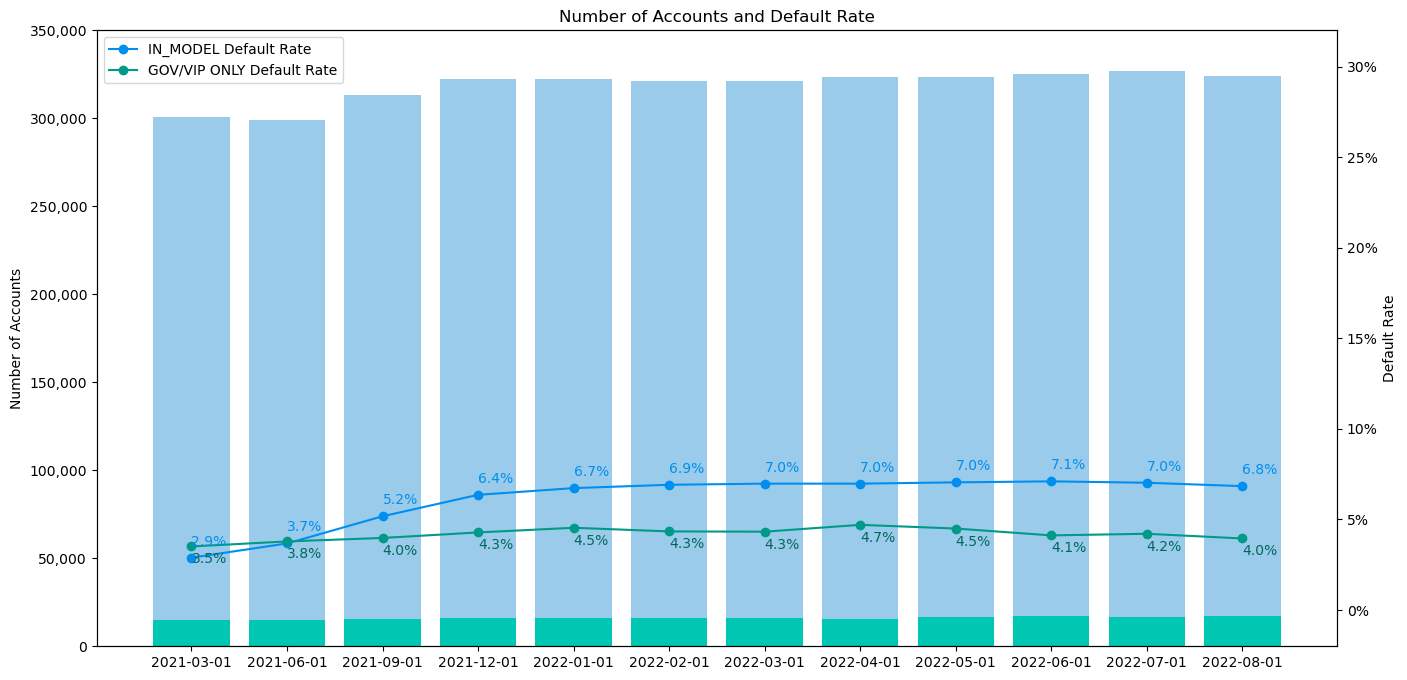

In [4]:
fig, ax1 = plt.subplots(figsize=(16, 8))

ax2 = ax1.twinx()
# Make REF_DATE discrete
ax1.bar(df_gov_vip.REF_DATE.astype(str), df_gov_vip.IN_MODEL, color='#9BCBEB')
ax2.plot(df_gov_vip.REF_DATE.astype(str), df_gov_vip.IN_MODEL_DEFAULT_RATE * 100, color='#008fef', marker='o', label='IN_MODEL Default Rate')

# ax1.bar(df_gov_vip.REF_DATE.astype(str), df_gov_vip.GOV_VIP_FLAG_WITH_OTHERS, color='#C8102E')
ax1.bar(df_gov_vip.REF_DATE.astype(str), df_gov_vip.GOV_VIP_FLAG_ONLY, color='#00C7B1')

# ax2.plot(df_gov_vip.REF_DATE.astype(str), df_gov_vip.GOV_VIP_FLAG_WITH_OTHERS_DEFAULT_RATE * 100, color='#C8102E', marker='o', label='GOV/VIP with Other Excl. Flags Default Rate')
ax2.plot(df_gov_vip.REF_DATE.astype(str), df_gov_vip.GOV_VIP_FLAG_ONLY_DEFAULT_RATE * 100, color='#019987', marker='o', label='GOV/VIP ONLY Default Rate')


# data label on ax2 as percent with 1 decimal place
for i, v in enumerate(df_gov_vip.IN_MODEL_DEFAULT_RATE):
    ax2.text(i, v * 100 + .5, "{:.1f}%".format(v * 100), color='#008fef', ha='left', va='bottom')
# for i, v in enumerate(df_gov_vip.GOV_VIP_FLAG_WITH_OTHERS_DEFAULT_RATE):
    # ax2.text(i, v * 100 + .5, "{:.1f}%".format(v * 100), color='#C8102E', ha='left', va='bottom')
for i, v in enumerate(df_gov_vip.GOV_VIP_FLAG_ONLY_DEFAULT_RATE):
    ax2.text(i, v * 100 - 1.1, "{:.1f}%".format(v * 100), color='#01685c', ha='left', va='bottom')


ax1.set_ylabel('Number of Accounts')
# y label format as number with comma
ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax1.set_ylim(0,350000)

ax2.set_ylabel('Default Rate')
# y label format as percent with 0 decimal place
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}%".format(x)))
ax2.set_ylim(-2,32)


plt.title('Number of Accounts and Default Rate')
plt.legend(loc='upper left')
plt.show()

### **Accounts with GOV / VIP Flag Only** - NOT with other exclusion flags

In [5]:
df_wx_cust_susp_class = all_acct.copy()

df_wx_cust_susp_class['EXCL_CRITERIA_SUM'] = \
    df_wx_cust_susp_class.EXCL_PORTFOLIO_FLAG \
    + df_wx_cust_susp_class.EXCL_CUST_STATUS_FLAG \
    + df_wx_cust_susp_class.EXCL_CUST_TENURE_FLAG \
    + df_wx_cust_susp_class.EXCL_GOV_VIP_FLAG \
    + df_wx_cust_susp_class.EXCL_DUMMY_CREDIT_LIMIT_FLAG \
    + df_wx_cust_susp_class.EXCL_LARGE_CREDIT_LIMIT_FLAG \
    + df_wx_cust_susp_class.EXCL_MATERIAL_DELINQUENCY_FLAG \
    + df_wx_cust_susp_class.EXCL_CUST_CONVERSION_FLAG \
    + df_wx_cust_susp_class.EXCL_FRAUD_FLAG \
    + df_wx_cust_susp_class.EXCL_EFPS_FLAG

df_wx_cust_susp_class['IN_MODEL'] = np.where((df_wx_cust_susp_class.EXCL_CRITERIA_SUM == 0), 1, 0)
# Get % of FLAG_60_DPD_366_DAYS = 1 where IN_MODEL = 1
df_wx_cust_susp_class['IN_MODEL_DEFAULT'] = np.where((df_wx_cust_susp_class.FLAG_60_DPD_366_DAYS == 1) & (df_wx_cust_susp_class.IN_MODEL == 1), 1, 0)

# Create a column called 'EXCL_GOV_VIP_FLAG_ONLY' where EXCL_GOV_VIP_FLAG = 1 and EXCL_CRITERIA_SUM = 1
df_wx_cust_susp_class['GOV_FLAG_ONLY'] = np.where((df_wx_cust_susp_class.EXCL_GOV_VIP_FLAG == 1) 
                                                       & ((df_wx_cust_susp_class.WX_CUST_SUSP_CLASS == 'G') | (df_wx_cust_susp_class.GOVERNMENT_FLG == 'Y'))
                                                       & (df_wx_cust_susp_class.EXCL_CRITERIA_SUM == 1), 1, 0)
df_wx_cust_susp_class['GOV_FLAG_DEFAULT'] = np.where((df_wx_cust_susp_class.FLAG_60_DPD_366_DAYS == 1) & (df_wx_cust_susp_class.GOV_FLAG_ONLY == 1), 1, 0)

df_wx_cust_susp_class['VIP_FLAG_ONLY'] = np.where((df_wx_cust_susp_class.EXCL_GOV_VIP_FLAG == 1) 
                                                       & ((df_wx_cust_susp_class.WX_CUST_SUSP_CLASS == 'V') & (df_wx_cust_susp_class.GOVERNMENT_FLG != 'Y'))
                                                       & (df_wx_cust_susp_class.EXCL_CRITERIA_SUM == 1), 1, 0)
df_wx_cust_susp_class['VIP_FLAG_DEFAULT'] = np.where((df_wx_cust_susp_class.FLAG_60_DPD_366_DAYS == 1) & (df_wx_cust_susp_class.VIP_FLAG_ONLY == 1), 1, 0)

df_wx_cust_susp_class['E_FLAG_ONLY'] = np.where((df_wx_cust_susp_class.EXCL_GOV_VIP_FLAG == 1) 
                                                       & ((df_wx_cust_susp_class.WX_CUST_SUSP_CLASS == 'E') & (df_wx_cust_susp_class.GOVERNMENT_FLG != 'Y'))
                                                       & (df_wx_cust_susp_class.EXCL_CRITERIA_SUM == 1), 1, 0)
df_wx_cust_susp_class['E_FLAG_DEFAULT'] = np.where((df_wx_cust_susp_class.FLAG_60_DPD_366_DAYS == 1) & (df_wx_cust_susp_class.E_FLAG_ONLY == 1), 1, 0)

df_wx_cust_susp_class['K_FLAG_ONLY'] = np.where((df_wx_cust_susp_class.EXCL_GOV_VIP_FLAG == 1) 
                                                       & ((df_wx_cust_susp_class.WX_CUST_SUSP_CLASS == 'K') & (df_wx_cust_susp_class.GOVERNMENT_FLG != 'Y'))
                                                       & (df_wx_cust_susp_class.EXCL_CRITERIA_SUM == 1), 1, 0)
df_wx_cust_susp_class['K_FLAG_DEFAULT'] = np.where((df_wx_cust_susp_class.FLAG_60_DPD_366_DAYS == 1) & (df_wx_cust_susp_class.K_FLAG_ONLY == 1), 1, 0)

df_wx_cust_susp_class = df_wx_cust_susp_class.groupby('REF_DATE').agg({'CUST_ID': 'nunique'
                                                                       , 'IN_MODEL': 'sum'
                                                                       , 'IN_MODEL_DEFAULT': 'sum'
                                                                       , 'GOV_FLAG_ONLY': 'sum'
                                                                       , 'GOV_FLAG_DEFAULT': 'sum'
                                                                       , 'VIP_FLAG_ONLY': 'sum'
                                                                       , 'VIP_FLAG_DEFAULT': 'sum'
                                                                       , 'E_FLAG_ONLY': 'sum'
                                                                       , 'E_FLAG_DEFAULT': 'sum'
                                                                       , 'K_FLAG_ONLY': 'sum'
                                                                       , 'K_FLAG_DEFAULT': 'sum'}).reset_index()

# Create a column for IN_MODEL_DEFAULT / IN_MODEL
df_wx_cust_susp_class['IN_MODEL_DEFAULT_RATE'] = df_wx_cust_susp_class['IN_MODEL_DEFAULT'] / df_wx_cust_susp_class['IN_MODEL']
df_wx_cust_susp_class['GOV_FLAG_DEFAULT_RATE'] = df_wx_cust_susp_class['GOV_FLAG_DEFAULT'] / df_wx_cust_susp_class['GOV_FLAG_ONLY']
df_wx_cust_susp_class['VIP_FLAG_DEFAULT_RATE'] = df_wx_cust_susp_class['VIP_FLAG_DEFAULT'] / df_wx_cust_susp_class['VIP_FLAG_ONLY']
df_wx_cust_susp_class['E_FLAG_DEFAULT_RATE'] = df_wx_cust_susp_class['E_FLAG_DEFAULT'] / df_wx_cust_susp_class['E_FLAG_ONLY']
df_wx_cust_susp_class['K_FLAG_DEFAULT_RATE'] = df_wx_cust_susp_class['K_FLAG_DEFAULT'] / df_wx_cust_susp_class['K_FLAG_ONLY']

df_wx_cust_susp_class = df_wx_cust_susp_class[['REF_DATE', 'CUST_ID', 'IN_MODEL', 'IN_MODEL_DEFAULT_RATE', 'GOV_FLAG_ONLY', 'GOV_FLAG_DEFAULT_RATE', 'VIP_FLAG_ONLY', 'VIP_FLAG_DEFAULT_RATE', 'E_FLAG_ONLY', 'E_FLAG_DEFAULT_RATE', 'K_FLAG_ONLY', 'K_FLAG_DEFAULT_RATE']]
df_wx_cust_susp_class

,REF_DATE,CUST_ID,IN_MODEL,IN_MODEL_DEFAULT_RATE,GOV_FLAG_ONLY,GOV_FLAG_DEFAULT_RATE,VIP_FLAG_ONLY,VIP_FLAG_DEFAULT_RATE,E_FLAG_ONLY,E_FLAG_DEFAULT_RATE,K_FLAG_ONLY,K_FLAG_DEFAULT_RATE
0,2021-03-01,520483,300531,0.028896,12683,0.039107,117,0.085470,695,0.001439,1352,0.010355
1,2021-06-01,537163,298991,0.036757,12778,0.042808,118,0.059322,719,0.001391,1356,0.008850
2,2021-09-01,555096,313032,0.051749,13141,0.045050,114,0.061404,748,0.001337,1428,0.009804
3,2021-12-01,579898,322219,0.063596,13607,0.047917,116,0.112069,764,0.002618,1483,0.011463
4,2022-01-01,585767,322176,0.067292,13698,0.050737,120,0.116667,762,0.003937,1474,0.011533
5,2022-02-01,590508,321454,0.069139,13648,0.048652,115,0.078261,765,0.003922,1486,0.012786
6,2022-03-01,597779,321022,0.069768,13605,0.048512,112,0.080357,758,0.003958,1502,0.012650
7,2022-04-01,601395,323730,0.069765,13802,0.050500,121,0.090909,34,0.000000,1523,0.013132
8,2022-05-01,603232,323616,0.070476,13978,0.050508,122,0.106557,769,0.002601,1581,0.012018
9,2022-06-01,606192,325077,0.071029,14047,0.048409,915,0.013115,778,0.003856,1590,0.011950


In [6]:
df_wx_cust_susp_class.columns

Index(['REF_DATE', 'CUST_ID', 'IN_MODEL', 'IN_MODEL_DEFAULT_RATE',
       'GOV_FLAG_ONLY', 'GOV_FLAG_DEFAULT_RATE', 'VIP_FLAG_ONLY',
       'VIP_FLAG_DEFAULT_RATE', 'E_FLAG_ONLY', 'E_FLAG_DEFAULT_RATE',
       'K_FLAG_ONLY', 'K_FLAG_DEFAULT_RATE'],
      dtype='object')

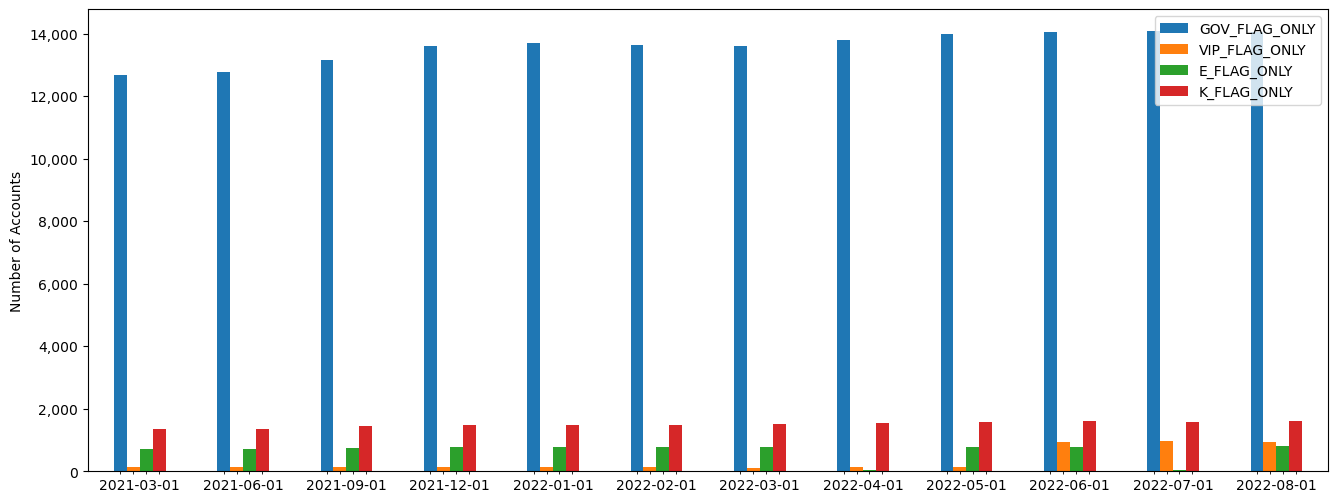

In [7]:
wx_cust_susp_class_plot = df_wx_cust_susp_class[['REF_DATE', 'GOV_FLAG_ONLY', 'VIP_FLAG_ONLY', 'E_FLAG_ONLY', 'K_FLAG_ONLY']]

wx_cust_susp_class_plot.plot(kind='bar',figsize=(16,6))

ax = plt.gca()
pos = []
for bar in ax.patches:
    pos.append(bar.get_x()+bar.get_width()/2)


ax.set_xticks(pos,minor=True)
lab = []
for i in range(len(pos)):
    l = wx_cust_susp_class_plot.columns.values[i//len(wx_cust_susp_class_plot.index.values)]
    lab.append(l)

ax.set_ylabel('Number of Accounts')
# y label format as number with comma
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
# ax.set_ylim(0,350000)

ax.set_xticklabels(wx_cust_susp_class_plot['REF_DATE'])
ax.tick_params(axis='x', which='major', pad=5, size=0)
plt.setp(ax.get_xticklabels(), rotation=0)

plt.show()

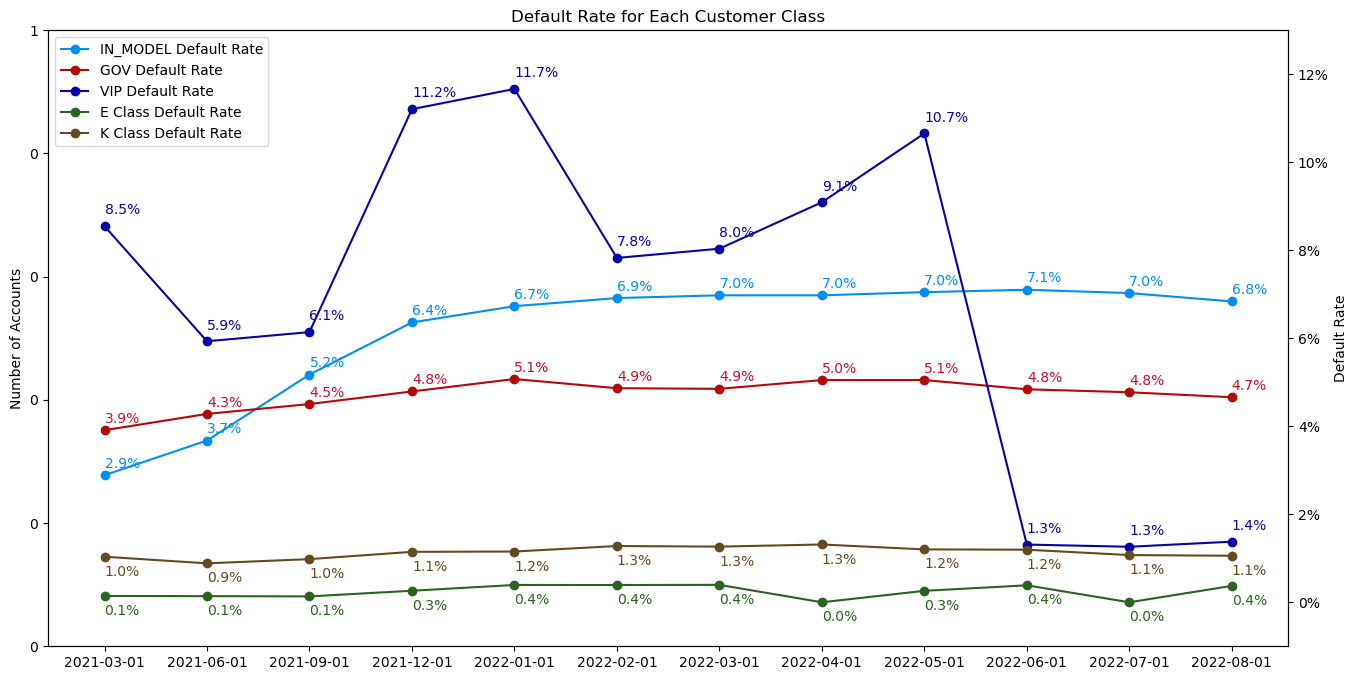

In [8]:
fig, ax1 = plt.subplots(figsize=(16, 8))

ax2 = ax1.twinx()
# Make REF_DATE discrete
# ax1.bar(df_wx_cust_susp_class.REF_DATE.astype(str), df_wx_cust_susp_class.IN_MODEL, color='#9bcbeb')
ax2.plot(df_wx_cust_susp_class.REF_DATE.astype(str), df_wx_cust_susp_class.IN_MODEL_DEFAULT_RATE * 100, color='#008fef', marker='o', label='IN_MODEL Default Rate')

# ax1.bar(df_wx_cust_susp_class.REF_DATE.astype(str), df_wx_cust_susp_class.GOV_FLAG_ONLY, color='#b30909')
ax2.plot(df_wx_cust_susp_class.REF_DATE.astype(str), df_wx_cust_susp_class.GOV_FLAG_DEFAULT_RATE * 100, color='#b30909', marker='o', label='GOV Default Rate')
ax2.plot(df_wx_cust_susp_class.REF_DATE.astype(str), df_wx_cust_susp_class.VIP_FLAG_DEFAULT_RATE * 100, color='#0803a5', marker='o', label='VIP Default Rate')
ax2.plot(df_wx_cust_susp_class.REF_DATE.astype(str), df_wx_cust_susp_class.E_FLAG_DEFAULT_RATE * 100, color='#2a631f', marker='o', label='E Class Default Rate')
ax2.plot(df_wx_cust_susp_class.REF_DATE.astype(str), df_wx_cust_susp_class.K_FLAG_DEFAULT_RATE * 100, color='#634a1f', marker='o', label='K Class Default Rate')

# data label on ax2 as percent with 1 decimal place
for i, v in enumerate(df_wx_cust_susp_class.IN_MODEL_DEFAULT_RATE):
    ax2.text(i, v * 100 + .1, "{:.1f}%".format(v * 100), color='#008fef', ha='left', va='bottom')
for i, v in enumerate(df_wx_cust_susp_class.GOV_FLAG_DEFAULT_RATE):
    ax2.text(i, v * 100 + .1, "{:.1f}%".format(v * 100), color='#c8102e', ha='left', va='bottom')
for i, v in enumerate(df_wx_cust_susp_class.VIP_FLAG_DEFAULT_RATE):
    ax2.text(i, v * 100 + .2, "{:.1f}%".format(v * 100), color='#0803a5', ha='left', va='bottom')
for i, v in enumerate(df_wx_cust_susp_class.E_FLAG_DEFAULT_RATE):
    ax2.text(i, v * 100 - .5, "{:.1f}%".format(v * 100), color='#2a631f', ha='left', va='bottom')
for i, v in enumerate(df_wx_cust_susp_class.K_FLAG_DEFAULT_RATE):
    ax2.text(i, v * 100 - .5, "{:.1f}%".format(v * 100), color='#634a1f', ha='left', va='bottom')

ax1.set_ylabel('Number of Accounts')
# y label format as number with comma
ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax2.set_ylabel('Default Rate')
# y label format as percent with 0 decimal place
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}%".format(x)))
ax2.set_ylim(-1,13)

plt.title('Default Rate for Each Customer Class')
plt.legend(loc='upper left')
plt.show()

In [9]:
df = all_acct.copy()

# Create a column called 'EXCL_CRITERIA_SUM' to sum up all exclusion criteria
df['EXCL_CRITERIA_SUM'] = \
    df.EXCL_PORTFOLIO_FLAG \
    + df.EXCL_CUST_STATUS_FLAG \
    + df.EXCL_CUST_TENURE_FLAG \
    + df.EXCL_GOV_VIP_FLAG \
    + df.EXCL_DUMMY_CREDIT_LIMIT_FLAG \
    + df.EXCL_LARGE_CREDIT_LIMIT_FLAG \
    + df.EXCL_MATERIAL_DELINQUENCY_FLAG \
    + df.EXCL_CUST_CONVERSION_FLAG \
    + df.EXCL_FRAUD_FLAG \
    + df.EXCL_EFPS_FLAG

df['IN_MODEL'] = np.where((df.EXCL_CRITERIA_SUM == 0), 1, 0)
df['EXCL_FROM_MODEL'] = np.where((df.EXCL_CRITERIA_SUM > 0), 1, 0)

# Create a column called 'EXCL_GOV_VIP_FLAG_ONLY' where EXCL_GOV_VIP_FLAG = 1 and EXCL_CRITERIA_SUM = 1
df['GOV_VIP_FLAG_ONLY'] = np.where((df.EXCL_GOV_VIP_FLAG == 1) & (df.EXCL_CRITERIA_SUM == 1), 1, 0)

# Create a column called 'EXCL_ONLY_GOV_VIP_FLAG' where EXCL_GOV_VIP_FLAG = 1 and EXCL_CRITERIA_SUM > 1
df['GOV_VIP_FLAG_WITH_OTHERS'] = np.where((df.EXCL_GOV_VIP_FLAG == 1) & (df.EXCL_CRITERIA_SUM > 1), 1, 0)

# Create a G,V,E,K flag
df['GOV_FLAG_ONLY'] = np.where((df.EXCL_GOV_VIP_FLAG == 1) 
                               & ((df.WX_CUST_SUSP_CLASS == 'G') | (df.GOVERNMENT_FLG == 'Y'))
                               & (df.EXCL_CRITERIA_SUM == 1), 1, 0)

df['VIP_FLAG_ONLY'] = np.where((df.EXCL_GOV_VIP_FLAG == 1)
                               & ((df.WX_CUST_SUSP_CLASS == 'V') & (df.GOVERNMENT_FLG != 'Y'))
                               & (df.EXCL_CRITERIA_SUM == 1), 1, 0)

df['E_FLAG_ONLY'] = np.where((df.EXCL_GOV_VIP_FLAG == 1) 
                             & ((df.WX_CUST_SUSP_CLASS == 'E') & (df.GOVERNMENT_FLG == 'Y'))
                             & (df.EXCL_CRITERIA_SUM == 1), 1, 0)

df['K_FLAG_ONLY'] = np.where((df.EXCL_GOV_VIP_FLAG == 1) 
                             & ((df.WX_CUST_SUSP_CLASS == 'K') & (df.GOVERNMENT_FLG == 'Y'))
                             & (df.EXCL_CRITERIA_SUM == 1), 1, 0)


In [10]:
df.head()

,CUST_ID,SETID,REF_DATE,A_NAICS_2_DIGIT_C,A_TENURE_MONTHS_N,A_FLAG_REVOLVER_B,A_YEARS_IN_BUSINESS_APP_N,A_FLEET_SIZE_APP_N,D_SPREAD_EXPOSURE_6M_N,D_MAX_DAYS_PAST_DUE_6M_N,...,GOVERNMENT_FLG,EXCL_CRITERIA_SUM,IN_MODEL,EXCL_FROM_MODEL,GOV_VIP_FLAG_ONLY,GOV_VIP_FLAG_WITH_OTHERS,GOV_FLAG_ONLY,VIP_FLAG_ONLY,E_FLAG_ONLY,K_FLAG_ONLY
0,9100007274538,WXB,2022-04-01,72,35,0,0.5,7.0,0.50954868,0.000,...,N,0,1,0,0,0,0,0,0,0
1,9100010210356,WXB,2022-07-01,Un,5,0,2.0,3.0,0.45815240,103.000,...,N,1,0,1,0,0,0,0,0,0
2,9100008531163,WXB,2022-04-01,56,18,0,3.0,2.0,0E-8,443.000,...,N,2,0,1,0,0,0,0,0,0
3,9100010210356,WXB,2022-04-01,Un,2,0,2.0,3.0,0.00257647,0.000,...,N,1,0,1,0,0,0,0,0,0
4,0539013002268,FSC,2022-07-01,23,56,0,NaN,NaN,0E-8,999.000,...,N,2,0,1,0,0,0,0,0,0


In [11]:
# from snowflake.connector.pandas_tools import write_pandas

# conn = snowflake_conn(database='SANDBOX', schema='DATA_SCIENCE__W510663', role='SANDBOX__DATA_SCIENCE__W510663__OWNER')
# cur = conn.cursor()

# write_pandas(conn, df, "NAF_PM_GOV_VIP_MAR21_AUG22", auto_create_table=True)

# conn.close()
# cur.close()

In [21]:
feature_list = ['A_NAICS_2_DIGIT_C', 'A_TENURE_MONTHS_N', 'A_FLAG_REVOLVER_B', 'A_YEARS_IN_BUSINESS_APP_N',
       'A_FLEET_SIZE_APP_N', 'D_SPREAD_EXPOSURE_6M_N',
       'D_MAX_DAYS_PAST_DUE_6M_N', 'D_MAX_EXPOSURE_1M_N', 'D_DAYS_SINCE_LAST_SUSPENSION_CURRENT_N', 'D_DAYS_SINCE_LAST_30DPD_CURRENT_N',
       'D_DAYS_PAST_DUE_CURRENT_N', 'D_SPREAD_FRAC_UNBILLED_6M_N', 'D_MAX_FRAC_UNBILLED_1M_N', 'D_MAX_DAYS_PAST_DUE_1M_N',
       'DNB_COMMERCIAL_CREDIT_SCORE_CURRENT_N', 'DNB_FINANCIAL_STRESS_SCORE_CURRENT_N', 'LN_LEXISNEXIS_SCORE_CURRENT_N', 'LN_LEXISNEXIS_SBFE_SCORE_CURRENT_N',
       'T_TOTAL_TRX_NON_FUEL_PROPORTION_1M_N', 'T_SPREAD_GROSS_SPEND_6M_N', 'T_SPREAD_TOTAL_TRX_6M_N', 'T_SUM_GALLONS_1M_N', 'T_SPREAD_SUM_GALLONS_6M_N',
]

columns_list = ['REF_DATE', 'CUST_ID', 'SETID', 'FLAG_90_DPD_366_DAYS', 'A_BUSINESS_PROGRAM_C', 'A_MARKETING_CHANNEL_C', 'FLAG_CHARGEOFF_366_DAYS', 'A_PORTFOLIO_C',
       'A_NAICS_2_DIGIT_C', 'A_TENURE_MONTHS_N', 'A_FLAG_REVOLVER_B', 'A_YEARS_IN_BUSINESS_APP_N', 'A_FLEET_SIZE_APP_N', 'D_SPREAD_EXPOSURE_6M_N',
       'D_MAX_DAYS_PAST_DUE_6M_N', 'D_MAX_EXPOSURE_1M_N', 'D_DAYS_SINCE_LAST_SUSPENSION_CURRENT_N', 'D_DAYS_SINCE_LAST_30DPD_CURRENT_N',
       'D_DAYS_PAST_DUE_CURRENT_N', 'D_SPREAD_FRAC_UNBILLED_6M_N', 'D_MAX_FRAC_UNBILLED_1M_N', 'D_MAX_DAYS_PAST_DUE_1M_N',
       'DNB_COMMERCIAL_CREDIT_SCORE_CURRENT_N', 'DNB_FINANCIAL_STRESS_SCORE_CURRENT_N', 'LN_LEXISNEXIS_SCORE_CURRENT_N', 'LN_LEXISNEXIS_SBFE_SCORE_CURRENT_N',
       'T_TOTAL_TRX_NON_FUEL_PROPORTION_1M_N', 'T_SPREAD_GROSS_SPEND_6M_N', 'T_SPREAD_TOTAL_TRX_6M_N', 'T_SUM_GALLONS_1M_N', 'T_SPREAD_SUM_GALLONS_6M_N',
       'FLAG_60_DPD_366_DAYS'
]

Text(0.5, 1.0, 'K_FLAG_ONLY Accounts')

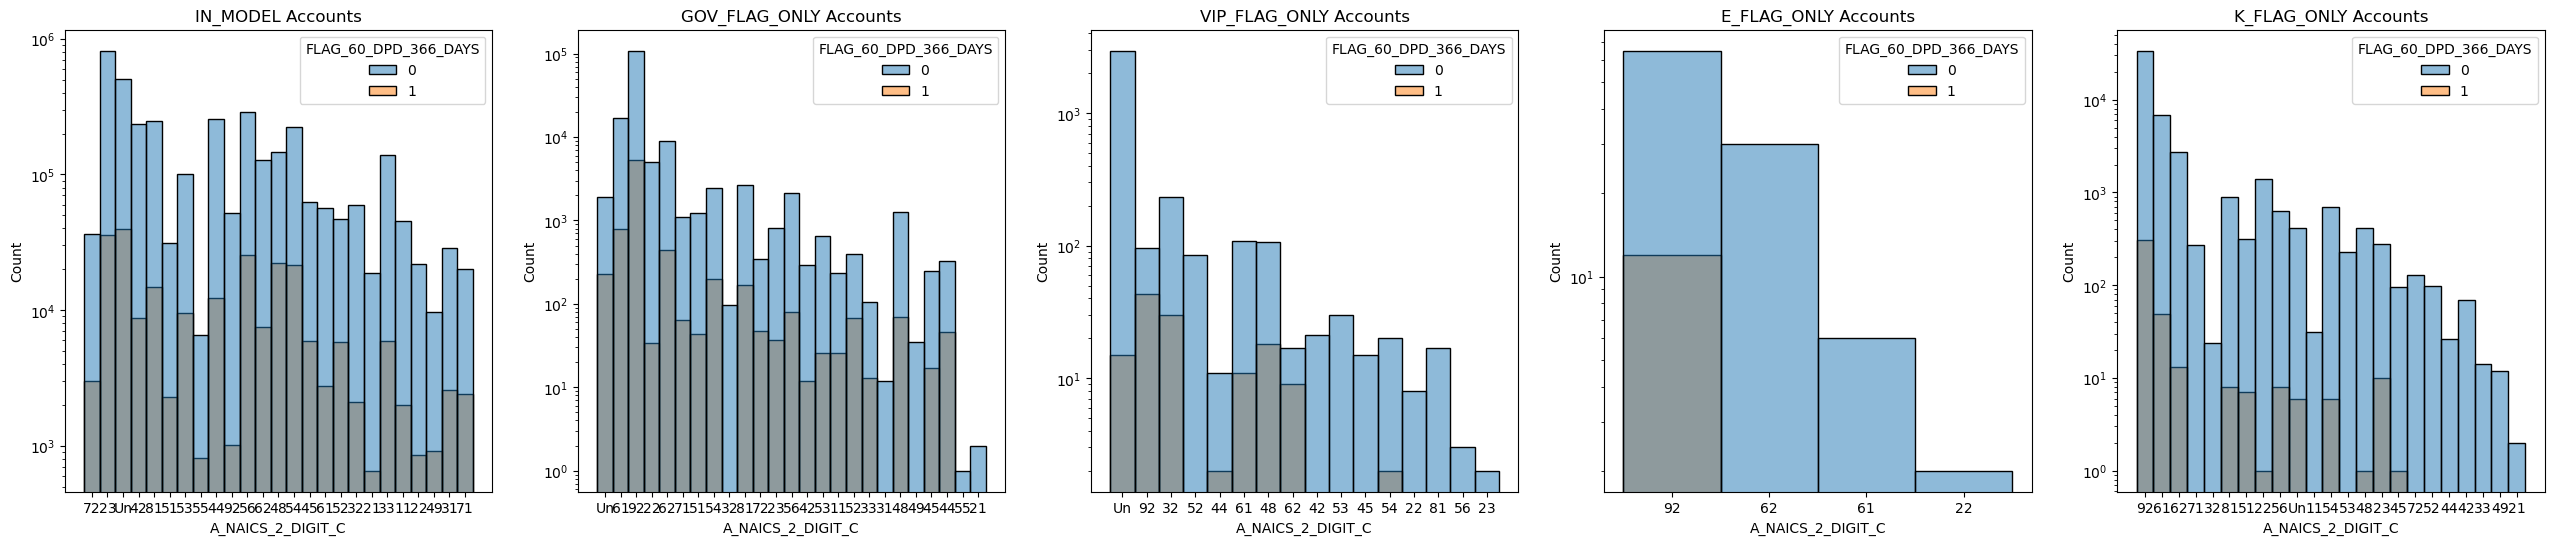

In [13]:
feature = 'A_NAICS_2_DIGIT_C'

fig,axs = plt.subplots(1,5, figsize = (32,6))

sns.histplot(data=df[df.IN_MODEL == 1], x=feature, hue='FLAG_60_DPD_366_DAYS', multiple='layer', bins=100, ax=axs[0])
axs[0].set_yscale('log')
axs[0].set_title('IN_MODEL Accounts')

sns.histplot(data=df[df.GOV_FLAG_ONLY == 1], x=feature, hue='FLAG_60_DPD_366_DAYS', multiple='layer', bins=100, ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_title('GOV_FLAG_ONLY Accounts')

sns.histplot(data=df[df.VIP_FLAG_ONLY == 1], x=feature, hue='FLAG_60_DPD_366_DAYS', multiple='layer', bins=100, ax=axs[2])
axs[2].set_yscale('log')
axs[2].set_title('VIP_FLAG_ONLY Accounts')

sns.histplot(data=df[df.E_FLAG_ONLY == 1], x=feature, hue='FLAG_60_DPD_366_DAYS', multiple='layer', bins=100, ax=axs[3])
axs[3].set_yscale('log')
axs[3].set_title('E_FLAG_ONLY Accounts')

sns.histplot(data=df[df.K_FLAG_ONLY == 1], x=feature, hue='FLAG_60_DPD_366_DAYS', multiple='layer', bins=100, ax=axs[4])
axs[4].set_yscale('log')
axs[4].set_title('K_FLAG_ONLY Accounts')

Text(0.5, 1.0, 'VIP_FLAGS Accounts')

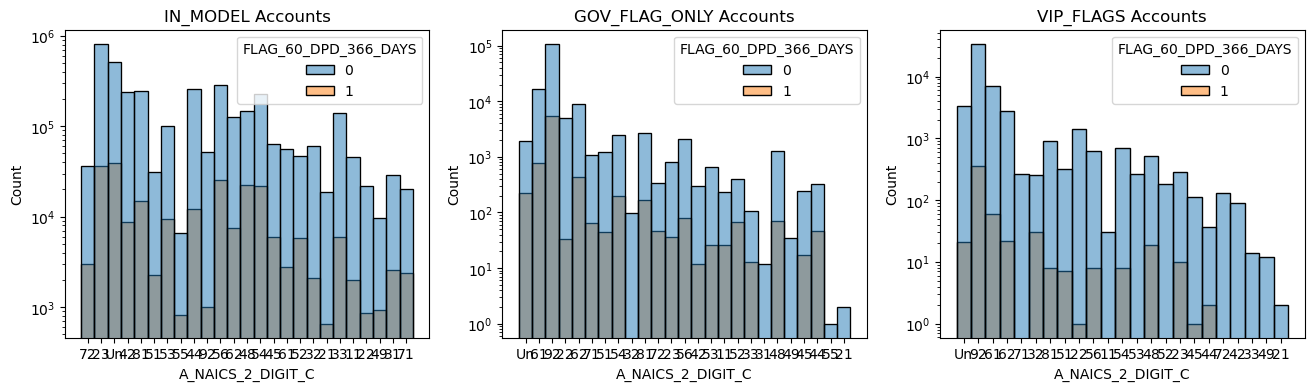

In [14]:
fig,axs = plt.subplots(1,3, figsize = (16,4))

sns.histplot(data=df[df.IN_MODEL == 1], x=feature, hue='FLAG_60_DPD_366_DAYS', multiple='layer', bins=100, ax=axs[0])
axs[0].set_yscale('log')
axs[0].set_title('IN_MODEL Accounts')

sns.histplot(data=df[df.GOV_FLAG_ONLY == 1], x=feature, hue='FLAG_60_DPD_366_DAYS', multiple='layer', bins=100, ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_title('GOV_FLAG_ONLY Accounts')

sns.histplot(data=df[(df.VIP_FLAG_ONLY == 1) | (df.E_FLAG_ONLY == 1) | (df.K_FLAG_ONLY == 1)], x=feature, hue='FLAG_60_DPD_366_DAYS', multiple='layer', bins=100, ax=axs[2])
axs[2].set_yscale('log')
axs[2].set_title('VIP_FLAGS Accounts')

---
### Missing Values

In [15]:
df_gov = df[df.GOV_FLAG_ONLY == 1].copy()
df_gov = df_gov[feature_list]
df_gov_na = pd.DataFrame(df_gov.isna().sum())
df_gov_na.rename(columns={df_gov_na.columns[0]: 'count'}, inplace = True)

# df_gov_na = df_gov_na[df_gov_na['count'] != 0]
df_gov_na['percent_missing'] = df_gov_na['count']/df.shape[0]
# df_gov_na = df_gov_na.sort_values('count', ascending=False)

df_gov_na

,count,percent_missing
A_NAICS_2_DIGIT_C,0,0.000000
A_TENURE_MONTHS_N,0,0.000000
A_FLAG_REVOLVER_B,0,0.000000
A_YEARS_IN_BUSINESS_APP_N,154387,0.022029
A_FLEET_SIZE_APP_N,81724,0.011661
D_SPREAD_EXPOSURE_6M_N,23,0.000003
D_MAX_DAYS_PAST_DUE_6M_N,0,0.000000
D_MAX_EXPOSURE_1M_N,0,0.000000
D_DAYS_SINCE_LAST_SUSPENSION_CURRENT_N,136059,0.019414
D_DAYS_SINCE_LAST_30DPD_CURRENT_N,133263,0.019015


In [16]:
df_in_model = df[df.IN_MODEL == 1].copy()
df_in_model = df_in_model[feature_list]
df_in_model_na = pd.DataFrame(df_in_model.isna().sum())
df_in_model_na.rename(columns={df_in_model_na.columns[0]: 'count'}, inplace = True)

# df_in_model_na = df_in_model_na[df_in_model_na['count'] != 0]
df_in_model_na['percent_missing'] = df_in_model_na['count']/df.shape[0]
# df_in_model_na = df_in_model_na.sort_values('count', ascending=False)

df_in_model_na

,count,percent_missing
A_NAICS_2_DIGIT_C,0,0.000000
A_TENURE_MONTHS_N,0,0.000000
A_FLAG_REVOLVER_B,0,0.000000
A_YEARS_IN_BUSINESS_APP_N,2368498,0.337961
A_FLEET_SIZE_APP_N,2063800,0.294484
D_SPREAD_EXPOSURE_6M_N,2248,0.000321
D_MAX_DAYS_PAST_DUE_6M_N,0,0.000000
D_MAX_EXPOSURE_1M_N,0,0.000000
D_DAYS_SINCE_LAST_SUSPENSION_CURRENT_N,2714042,0.387267
D_DAYS_SINCE_LAST_30DPD_CURRENT_N,3542493,0.505478


Text(0.5, 1.0, 'IN_MODEL Accounts')

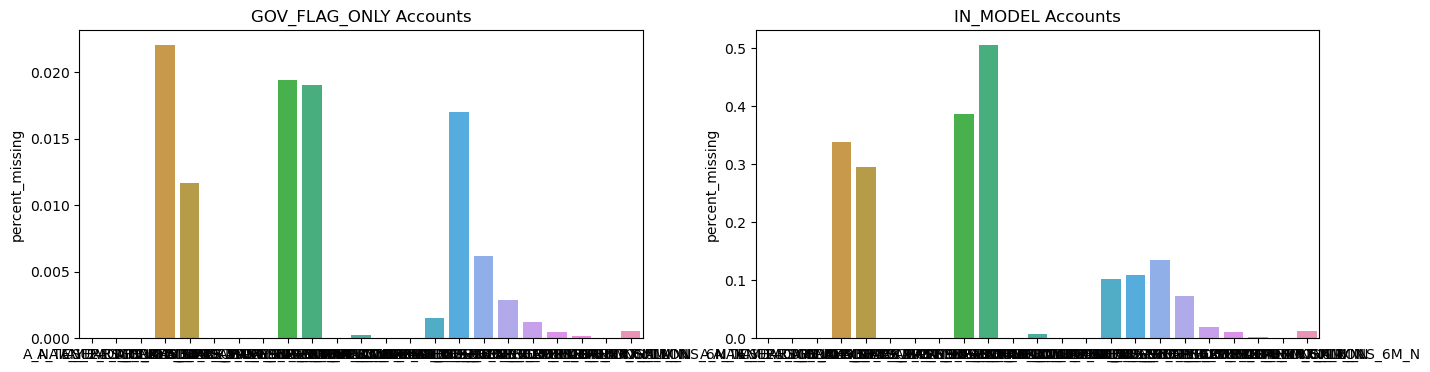

In [17]:
# plot percent_missing of each feature from df_gov_na and df_in_model_na
fig,axs = plt.subplots(1,2, figsize = (16,4))

# horizontal bar plot

sns.barplot(x=df_gov_na.index, y='percent_missing', data=df_gov_na, ax=axs[0])
axs[0].set_title('GOV_FLAG_ONLY Accounts')

sns.barplot(x=df_in_model_na.index, y='percent_missing', data=df_in_model_na, ax=axs[1])
axs[1].set_title('IN_MODEL Accounts')


---
### Model Scoring

In [18]:
# %pip install dataiku-scoring

In [19]:
import dataikuscoring

model = dataikuscoring.load_model('dataiku-models/flag_60_dpd_366_days-incl-lexisnexis-weights/model.zip')

In [25]:
df_pred = df[columns_list]

df_pred.head()

,REF_DATE,CUST_ID,SETID,FLAG_90_DPD_366_DAYS,A_BUSINESS_PROGRAM_C,A_MARKETING_CHANNEL_C,FLAG_CHARGEOFF_366_DAYS,A_PORTFOLIO_C,A_NAICS_2_DIGIT_C,A_TENURE_MONTHS_N,...,DNB_COMMERCIAL_CREDIT_SCORE_CURRENT_N,DNB_FINANCIAL_STRESS_SCORE_CURRENT_N,LN_LEXISNEXIS_SCORE_CURRENT_N,LN_LEXISNEXIS_SBFE_SCORE_CURRENT_N,T_TOTAL_TRX_NON_FUEL_PROPORTION_1M_N,T_SPREAD_GROSS_SPEND_6M_N,T_SPREAD_TOTAL_TRX_6M_N,T_SUM_GALLONS_1M_N,T_SPREAD_SUM_GALLONS_6M_N,FLAG_60_DPD_366_DAYS
0,2022-04-01,9100007274538,WXB,0,Shell Fleet Navigator,Generic,0,WXB,72,35,...,598.0,1504.0,691.0,718.0,0.011111,0.87982538,0.590674,1592.13500,0.51291862152,0
1,2022-07-01,9100010210356,WXB,1,Shell Fleet Plus,Banner Advertisement,1,WXB,Un,5,...,492.0,1407.0,681.0,501.0,1.000000,2.80126664,2.625000,0.00000,3.10323644844,1
2,2022-04-01,9100008531163,WXB,1,Shell Fleet Plus,Banner Advertisement,1,WXB,56,18,...,214.0,1297.0,694.0,544.0,None,None,None,0.00000,None,1
3,2022-04-01,9100010210356,WXB,1,Shell Fleet Plus,Banner Advertisement,1,WXB,Un,2,...,514.0,1471.0,681.0,561.0,0.083333,3.05608137,3.230769,142.77000,3.36124202939,1
4,2022-07-01,0539013002268,FSC,1,LUKOIL Fleet,None,1,FSC,23,56,...,568.0,1493.0,NaN,669.0,None,None,None,0.00000,None,1


In [26]:
df_pred_proba = model.predict_proba(df_pred)

In [28]:
df['proba_0'] = df_pred_proba['0']
df['proba_1'] = df_pred_proba['1']

In [29]:
df.head()

,CUST_ID,SETID,REF_DATE,A_NAICS_2_DIGIT_C,A_TENURE_MONTHS_N,A_FLAG_REVOLVER_B,A_YEARS_IN_BUSINESS_APP_N,A_FLEET_SIZE_APP_N,D_SPREAD_EXPOSURE_6M_N,D_MAX_DAYS_PAST_DUE_6M_N,...,IN_MODEL,EXCL_FROM_MODEL,GOV_VIP_FLAG_ONLY,GOV_VIP_FLAG_WITH_OTHERS,GOV_FLAG_ONLY,VIP_FLAG_ONLY,E_FLAG_ONLY,K_FLAG_ONLY,proba_0,proba_1
0,9100007274538,WXB,2022-04-01,72,35,0,0.5,7.0,0.50954868,0.000,...,1,0,0,0,0,0,0,0,0.985883,0.014117
1,9100010210356,WXB,2022-07-01,Un,5,0,2.0,3.0,0.45815240,103.000,...,0,1,0,0,0,0,0,0,0.293870,0.706130
2,9100008531163,WXB,2022-04-01,56,18,0,3.0,2.0,0E-8,443.000,...,0,1,0,0,0,0,0,0,0.642128,0.357872
3,9100010210356,WXB,2022-04-01,Un,2,0,2.0,3.0,0.00257647,0.000,...,0,1,0,0,0,0,0,0,0.453208,0.546792
4,0539013002268,FSC,2022-07-01,23,56,0,NaN,NaN,0E-8,999.000,...,0,1,0,0,0,0,0,0,0.817623,0.182377


In [30]:
# from snowflake.connector.pandas_tools import write_pandas

# conn = snowflake_conn(database='DATAIKU_RAW_SUB', schema='RISK_FRAUD', role='DATA_SCIENCE_ROLE')
# cur = conn.cursor()

# write_pandas(conn, df, "NAF_PM_GOV_VIP_PRED_MAR21_AUG22", auto_create_table=True)

# conn.close()
# cur.close()

False

In [ ]:
# calcu

In [35]:
df_pred_susp_class.IN_MODEL

AttributeError: 'DataFrame' object has no attribute 'IN_MODEL'

In [36]:
df_pred_susp_class = df.copy()

df_pred_susp_class.groupby(['REF_DATE', 'IN_MODEL'])['proba_1'].mean()

# df_pred_susp_class['IN_MODEL'] = np.where((df_pred_susp_class.IN_MODEL == 0), 1, 0)
# # Get % of FLAG_60_DPD_366_DAYS = 1 where IN_MODEL = 1
# df_pred_susp_class['IN_MODEL_DEFAULT'] = np.where((df_pred_susp_class.FLAG_60_DPD_366_DAYS == 1) & (df_pred_susp_class.IN_MODEL == 1), 1, 0)

# # Create a column called 'EXCL_GOV_VIP_FLAG_ONLY' where EXCL_GOV_VIP_FLAG = 1 and EXCL_CRITERIA_SUM = 1
# df_pred_susp_class['GOV_FLAG_ONLY'] = np.where((df_pred_susp_class.EXCL_GOV_VIP_FLAG == 1) 
#                                                        & ((df_pred_susp_class.WX_CUST_SUSP_CLASS == 'G') | (df_pred_susp_class.GOVERNMENT_FLG == 'Y'))
#                                                        & (df_pred_susp_class.EXCL_CRITERIA_SUM == 1), 1, 0)
# df_pred_susp_class['GOV_FLAG_DEFAULT'] = np.where((df_pred_susp_class.FLAG_60_DPD_366_DAYS == 1) & (df_pred_susp_class.GOV_FLAG_ONLY == 1), 1, 0)

# df_pred_susp_class['VIP_FLAG_ONLY'] = np.where((df_pred_susp_class.EXCL_GOV_VIP_FLAG == 1) 
#                                                        & ((df_pred_susp_class.WX_CUST_SUSP_CLASS == 'V') & (df_pred_susp_class.GOVERNMENT_FLG != 'Y'))
#                                                        & (df_pred_susp_class.EXCL_CRITERIA_SUM == 1), 1, 0)
# df_pred_susp_class['VIP_FLAG_DEFAULT'] = np.where((df_pred_susp_class.FLAG_60_DPD_366_DAYS == 1) & (df_pred_susp_class.VIP_FLAG_ONLY == 1), 1, 0)

# df_pred_susp_class['E_FLAG_ONLY'] = np.where((df_pred_susp_class.EXCL_GOV_VIP_FLAG == 1) 
#                                                        & ((df_pred_susp_class.WX_CUST_SUSP_CLASS == 'E') & (df_pred_susp_class.GOVERNMENT_FLG != 'Y'))
#                                                        & (df_pred_susp_class.EXCL_CRITERIA_SUM == 1), 1, 0)
# df_pred_susp_class['E_FLAG_DEFAULT'] = np.where((df_pred_susp_class.FLAG_60_DPD_366_DAYS == 1) & (df_pred_susp_class.E_FLAG_ONLY == 1), 1, 0)

# df_pred_susp_class['K_FLAG_ONLY'] = np.where((df_pred_susp_class.EXCL_GOV_VIP_FLAG == 1) 
#                                                        & ((df_pred_susp_class.WX_CUST_SUSP_CLASS == 'K') & (df_pred_susp_class.GOVERNMENT_FLG != 'Y'))
#                                                        & (df_pred_susp_class.EXCL_CRITERIA_SUM == 1), 1, 0)
# df_pred_susp_class['K_FLAG_DEFAULT'] = np.where((df_pred_susp_class.FLAG_60_DPD_366_DAYS == 1) & (df_pred_susp_class.K_FLAG_ONLY == 1), 1, 0)

# df_pred_susp_class = df_pred_susp_class.groupby('REF_DATE').agg({'CUST_ID': 'nunique'
#                                                                        , 'IN_MODEL': 'sum'
#                                                                        , 'IN_MODEL_DEFAULT': 'sum'
#                                                                        , 'GOV_FLAG_ONLY': 'sum'
#                                                                        , 'GOV_FLAG_DEFAULT': 'sum'
#                                                                        , 'VIP_FLAG_ONLY': 'sum'
#                                                                        , 'VIP_FLAG_DEFAULT': 'sum'
#                                                                        , 'E_FLAG_ONLY': 'sum'
#                                                                        , 'E_FLAG_DEFAULT': 'sum'
#                                                                        , 'K_FLAG_ONLY': 'sum'
#                                                                        , 'K_FLAG_DEFAULT': 'sum'}).reset_index()

# # Create a column for IN_MODEL_DEFAULT / IN_MODEL
# df_pred_susp_class['IN_MODEL_DEFAULT_RATE'] = df_pred_susp_class['IN_MODEL_DEFAULT'] / df_pred_susp_class['IN_MODEL']
# df_pred_susp_class['GOV_FLAG_DEFAULT_RATE'] = df_pred_susp_class['GOV_FLAG_DEFAULT'] / df_pred_susp_class['GOV_FLAG_ONLY']
# df_pred_susp_class['VIP_FLAG_DEFAULT_RATE'] = df_pred_susp_class['VIP_FLAG_DEFAULT'] / df_pred_susp_class['VIP_FLAG_ONLY']
# df_pred_susp_class['E_FLAG_DEFAULT_RATE'] = df_pred_susp_class['E_FLAG_DEFAULT'] / df_pred_susp_class['E_FLAG_ONLY']
# df_pred_susp_class['K_FLAG_DEFAULT_RATE'] = df_pred_susp_class['K_FLAG_DEFAULT'] / df_pred_susp_class['K_FLAG_ONLY']

# df_pred_susp_class = df_pred_susp_class[['REF_DATE', 'CUST_ID', 'IN_MODEL', 'IN_MODEL_DEFAULT_RATE', 'GOV_FLAG_ONLY', 'GOV_FLAG_DEFAULT_RATE', 'VIP_FLAG_ONLY', 'VIP_FLAG_DEFAULT_RATE', 'E_FLAG_ONLY', 'E_FLAG_DEFAULT_RATE', 'K_FLAG_ONLY', 'K_FLAG_DEFAULT_RATE']]
# df_pred_susp_class

IN_MODEL
0    0.135168
1    0.051294
Name: proba_1, dtype: float64